# W266 Final Project
# Resampling
# October 9, 2022
# John Clark, Shrinivas Joshi, Courtney Kennedy

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/cakennedy/266-mbti-project/blob/main/notebooks/Resampling.ipynb#)


# There are several different resampling strategies to try

#### First, we want to look at using the four letter types as well as the categorical variables, and create new distributions by under and over sampling based on both ways of organizing the data.

#### Second, we want to try over/under sampling to get to different distributions.  These will include a uniform distribution across all categories and then a distribution that matches the natural distribution found in the general population.

In [1]:
# Google collab premium utilities status check
# GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

print( '\n')

# RAM
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Not connected to a GPU


Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [2]:
# imports
import sys
import csv


import pandas as pd
import io
from io import BytesIO
import matplotlib.pyplot as plt
import altair as alt
import numpy as np
import textwrap

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk import word_tokenize
from nltk.corpus import stopwords
import re
import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn.utils import resample
from sklearn.utils import shuffle


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [3]:
# Configuration Flags

useGCloudForStorage = True



In [4]:

# Global State Flags
uploadedGCloudCredentials = False
mountedGoogleDrive = False
configuredGCloud = False


# Global Variables
gdrive_path = '/content/drive/MyDrive/content/drive/'

gcloud_bucket = None
gcloud_bucket_name = ""

In [5]:
# To work from a google drive use this:
from google.colab import drive

def mount_google_drive():
    global userGCloudForStorage
    global mountedGoogleDrive

    if useGCloudForStorage == False:
        if mountedGoogleDrive == False:
            drive.mount('/content/drive')
            mountedGoogleDrive = True



In [6]:
# To work from gcloud, use this:

# Upload Google Cloud service account key to enable authentication ( json file )
# Go to https://console.cloud.google.com/:
# Under the Navigation Menu ( upper left 3 horizontal lines) 
# 1. choose IAM & Admin>
# 2. choose Service Accounts>
# 3. Select a Service Account>
# 4. Under the Actions menu ( 3 dots to the right of the service account )>Manage Keys to create your own json credentials file

from google.colab import files
from google.cloud import storage


def upload_gcloud_credentials():
    global useGCloudForStorage
    global uploadedGCloudCredentials

    if useGCloudForStorage:
        if uploadedGCloudCredentials == False:

            uploaded = files.upload()
            uploadedGCloudCredentials = True


def config_GCloud():
    global configuredGCloud
    global gcloud_bucket
    global gcloud_bucket_name

    if configuredGCloud:
        return gcloud_bucket, gcloud_bucket_name

    #Load Google Cloud storage client using service key
    storage_client = storage.Client.from_service_account_json('pacific-castle-360400-a3ca89f64de6.json')
    #Print buckets available
    for bucket in storage_client.list_buckets():
        print(bucket)

    #Assign bucket name being used
    gcloud_bucket_name = '266csffile'

    #Get bucket
    gcloud_bucket = storage_client.get_bucket(gcloud_bucket_name)

    #Show list of files in bucket and list the files
    filename = list(gcloud_bucket.list_blobs(prefix=''))
    for name in filename:
        print(name.name)

    #Increase field size to allow reading in of files
    maxInt = sys.maxsize

    while True:
        # decrease the maxInt value by factor 10 as long as overflow error occurs 
        try:
            csv.field_size_limit(maxInt)
            break
        except OverflowError:
            maxInt = int(maxInt/10)

    configuredGCloud = True

    return gcloud_bucket, gcloud_bucket_name


In [7]:
# Read source data files in and create dataframes

def read_sources_from_Drive():
    global useGCloudForStorage

    if useGCloudForStorage == True:  
        return

    mount_google_drive()

    # test file is a 1000 row file to use in developing data cleaning routines before tackling the real files
    # test_posts_df = pd.read_csv( '/content/drive/MyDrive/content/drive/test_posts.csv')

    # Two forms of Posts files- both a full dataframe and an iterator
    posts_full_df = pd.read_csv('/content/drive/MyDrive/content/drive/typology_xenforo-9-25-22-posts.csv')
    posts_iterator = pd.read_csv('/content/drive/MyDrive/content/drive/typology_xenforo-9-25-22-posts.csv', chunksize = 10000)

    header_df = pd.read_csv('/content/drive/MyDrive/content/drive/typology_xenforo.csv')

    return header_df, posts_full_df, posts_iterator


def read_sources_from_GCloud():
    global useGCloudForStorage

    if useGCloudForStorage == False:
        return

    upload_gcloud_credentials()
    bucket, bucket_name = config_GCloud()

    #Grab blob header file and download as string
    users = bucket.blob('typology_xenforo-9-25-22.csv')
    string_data_users = users.download_as_string()
    print( string_data_users )

    #Convert to pandas
    header_df = pd.read_csv(io.BytesIO(string_data_users), encoding='utf-8', sep=',', engine='python')

    #Grab blob posts file and download as string
    posts = bucket.blob('typology_xenforo-9-25-22-posts.csv')
    string_data_posts = posts.download_as_string()
    print( string_data_posts)

    #Convert to pandas
    posts_full_df = pd.read_csv(io.BytesIO(string_data_posts), encoding='utf-8', sep=',', engine='python')

    posts_iterator = pd.read_csv(io.BytesIO(string_data_posts), encoding='utf-8', sep=',', chunksize = 10000)

    return header_df, posts_full_df, posts_iterator



In [8]:
# write parquet files

def write_parquet_gdrive( df, filename):
    global gdrive_path

    full_path_to_file = gdrive_path + filename

    print( full_path_to_file)
    df.to_parquet(full_path_to_file)


def write_parquet_google_cloud( df, filename):

    bucket, bucket_name = config_GCloud()

    blob = bucket.blob( filename )
    blob.upload_from_string(df.to_parquet(), 'application/octet-stream')

def write_parquet_file( dataframe, filename):

    global useGCloudForStorage

    if useGCloudForStorage:
        write_parquet_google_cloud( dataframe, filename )
    else:
        write_parquet_gdrive( dataframe, filename )



In [9]:
# utility for writing a csv to our shared GCloud storage

def write_csv_file( dataframe, 
                    filename,
                    index,
                    header,
                    mode ):
    '''This function writes a panda to a CSV file in the Google cloud storage 
    bucket. Input parameters include the dataframe, the name of the file to 
    write, the index (write row names), header(create column names) and 
    mode(write) '''

    bucket, bucket_name = config_GCloud()
    blob = bucket.blob( filename )
    blob.upload_from_string(dataframe.to_csv(index=index, header=header, mode=mode), 'text/csv')



In [10]:
upload_gcloud_credentials()
bucket, bucket_name = config_GCloud()



Saving pacific-castle-360400-a3ca89f64de6.json to pacific-castle-360400-a3ca89f64de6.json
<Bucket: 266csffile>
dev_mbti_data.csv
dev_mbti_labels.csv
test_mbti_data.csv
test_mbti_labels.csv
train_gen_pop_mbti_data.csv
train_gen_pop_mbti_labels.csv
train_mbti_data.csv
train_mbti_labels.csv
train_over_sampled_mbti_data.csv
train_over_sampled_mbti_labels.csv
train_under_sampled_mbti_data.csv
train_under_sampled_mbti_labels.csv
typology_merged.parquet
typology_users_clean.csv
typology_xenforo-9-25-22-posts.csv
typology_xenforo-9-25-22.csv
typology_xenforo-9-25-22_clean.parquet


In [11]:
# read in the already cleaned posts data

posts_filename = 'typology_xenforo-9-25-22_clean.parquet'

print( posts_filename)

# read back and look for corruption
bucket, bucket_name = config_GCloud()

read_back = bucket.blob(posts_filename)
string_read_back = read_back.download_as_string()
posts_df = pd.read_parquet(io.BytesIO(string_read_back))




typology_xenforo-9-25-22_clean.parquet


In [12]:
# read in the already cleaned header(user) data

header_filename = 'typology_users_clean.csv'

bucket, bucket_name = config_GCloud()

header_blob = bucket.blob( header_filename )
header_string = header_blob.download_as_string()
   
users_df = pd.read_csv(io.BytesIO(header_string), engine='python')





In [31]:
def read_csv_from_gcloud( filename ):

    bucket, bucket_name = config_GCloud()

    blob = bucket.blob( filename )
    blob_string = blob.download_as_string()
    
    read_df = pd.read_csv(io.BytesIO(blob_string), engine='python')
    return read_df




In [22]:
def read_parquet_from_gcloud( filename ):

    bucket, bucket_name = config_GCloud()

    blob = bucket.blob( filename )
    blob_string = blob.download_as_string()
    
    read_df = pd.read_parquet(io.BytesIO(blob_string))
    return read_df





In [13]:
# read in the already cleaned, merged data

#Merge the post database and header database
merged_df = users_df.merge(posts_df, on='Username')


print("merged data shape:", merged_df.shape)
print( "merged data columns:", merged_df.columns )
print(merged_df.head(2))




merged data shape: (1611083, 17)
merged data columns: Index(['Unnamed: 0', 'Username', 'Age', 'Posts', 'MBTI Type', 'Enneagram',
       'Instinctual Variant', 'Gender', 'Occupation', 'is_I', 'is_S', 'is_T',
       'is_J', 'post_id', 'thread_id', 'post_date', 'message'],
      dtype='object')
   Unnamed: 0   Username   Age  Posts MBTI Type Enneagram Instinctual Variant  \
0          12  (FL)Cross  31.0      3      ENTP       NaN                 NaN   
1          12  (FL)Cross  31.0      3      ENTP       NaN                 NaN   

  Gender Occupation   is_I   is_S  is_T   is_J  post_id  thread_id  \
0    NaN        NaN  False  False  True  False  1087131      28751   
1    NaN        NaN  False  False  True  False  1087167      28480   

    post_date                                            message  
0  1268893290    ooh ooh ooh, how about listing bad pick up l...  
1  1268894726  how can you tell if an XXXX likes you?  they j...  


In [14]:
# take stock of what we have


# merged statistics

print( "merged shape:", merged_df.shape )
print( "merged columns:", merged_df.columns )
print( "merged index:", merged_df.index )

merged_df = merged_df.drop(['Unnamed: 0'], axis=1)

print( "merged shape:", merged_df.shape )
print( "merged columns:", merged_df.columns )








merged shape: (1611083, 17)
merged columns: Index(['Unnamed: 0', 'Username', 'Age', 'Posts', 'MBTI Type', 'Enneagram',
       'Instinctual Variant', 'Gender', 'Occupation', 'is_I', 'is_S', 'is_T',
       'is_J', 'post_id', 'thread_id', 'post_date', 'message'],
      dtype='object')
merged index: Int64Index([      0,       1,       2,       3,       4,       5,       6,
                  7,       8,       9,
            ...
            1611073, 1611074, 1611075, 1611076, 1611077, 1611078, 1611079,
            1611080, 1611081, 1611082],
           dtype='int64', length=1611083)
merged shape: (1611083, 16)
merged columns: Index(['Username', 'Age', 'Posts', 'MBTI Type', 'Enneagram',
       'Instinctual Variant', 'Gender', 'Occupation', 'is_I', 'is_S', 'is_T',
       'is_J', 'post_id', 'thread_id', 'post_date', 'message'],
      dtype='object')


In [15]:
# write out merged_df to a parquet file
merged_filename = 'typology_merged.parquet'

print( merged_filename)
write_parquet_file( merged_df, merged_filename)




typology_merged.parquet


##Break up merged data in to Train, Test and Dev sets.
## Also break up into data ( X ) and labels ( y ), using the 'MBTI Type' column as the label.


In [16]:

# Shuffle the data
shuffle = np.random.permutation(np.arange(merged_df.shape[0]))



In [18]:
# Separate out the labels column 'MBTI type
labels_df = merged_df['MBTI Type']
data_df = merged_df.drop(columns=['MBTI Type'])

print( "Labels shape:", labels_df.shape )
print( "Labels head:", labels_df.head())

print( "Data shape:", data_df.shape )
print( "Data columns:", data_df.columns )



Labels shape: (1611083,)
Labels head: 0    ENTP
1    ENTP
2    ENTP
3    INFJ
4    INFJ
Name: MBTI Type, dtype: object
Data shape: (1611083, 15)
Data columns: Index(['Username', 'Age', 'Posts', 'Enneagram', 'Instinctual Variant',
       'Gender', 'Occupation', 'is_I', 'is_S', 'is_T', 'is_J', 'post_id',
       'thread_id', 'post_date', 'message'],
      dtype='object')


In [19]:
# Divide into Train, Test and Dev sets

# Set some variables to hold test, dev, and training data.
train_mbti_data, train_mbti_labels = data_df[:1200000], labels_df[:1200000]
dev_mbti_data, dev_mbti_labels = data_df[1200000:1400000], labels_df[1200000:1400000]
test_mbti_data, test_mbti_labels = data_df[1400000:1600000], labels_df[1400000:1600000]

#Determine and print number of rows in each dataset
train_mbti_rows = train_mbti_data.shape[0]
dev_mbti_rows = dev_mbti_data.shape[0]
test_mbti_rows = test_mbti_data.shape[0]
total_mbti_records = train_mbti_rows+dev_mbti_rows+test_mbti_rows
print('After Data Split')
print(' TRAIN dataset row count: ', '{:,}'.format(train_mbti_rows))
print(' DEV dataset row count  : ', '{:,}'.format(dev_mbti_rows))
print(' TEST dataset row count : ', '{:,}'.format(test_mbti_rows))
print(' Total rows             : ', '{:,}'.format(total_mbti_records))

null_data = train_mbti_data.isnull().sum()
print(' There are', '{:,}'.format(null_data['message']), 'missing message rows in the Train dataset')
null_data = dev_mbti_data.isnull().sum()
print(' There are', '{:,}'.format(null_data['message']), 'missing message rows in the Dev dataset')
null_data = test_mbti_data.isnull().sum()
print(' There are', '{:,}'.format(null_data['message']), 'missing message rows in the Test dataset')

#Set option to print dataframe in one line
pd.set_option('expand_frame_repr', False)

#Check that data looks good
print('\nExample of data after cleaning and splitting:')
print('\nTraining data')
print(train_mbti_data.head(10))
print('\nTraining labels')
print(train_mbti_labels.head(10))
print('')

After Data Split
 TRAIN dataset row count:  1,200,000
 DEV dataset row count  :  200,000
 TEST dataset row count :  200,000
 Total rows             :  1,600,000
 There are 0 missing message rows in the Train dataset
 There are 0 missing message rows in the Dev dataset
 There are 0 missing message rows in the Test dataset

Example of data after cleaning and splitting:

Training data
    Username   Age  Posts Enneagram Instinctual Variant  Gender Occupation   is_I   is_S   is_T   is_J  post_id  thread_id   post_date                                            message
0  (FL)Cross  31.0      3       NaN                 NaN     NaN        NaN  False  False   True  False  1087131      28751  1268893290    ooh ooh ooh, how about listing bad pick up l...
1  (FL)Cross  31.0      3       NaN                 NaN     NaN        NaN  False  False   True  False  1087167      28480  1268894726  how can you tell if an XXXX likes you?  they j...
2  (FL)Cross  31.0      3       NaN                 NaN  

In [21]:
# write out un-resampled train, test and dev sets to files

train_data_filename = 'train_mbti_data.parquet'
train_labels_filename = 'train_mbti_labels.csv'

write_parquet_file( train_mbti_data, train_data_filename)
write_csv_file(train_mbti_labels, train_labels_filename, True, True, 'w')

test_data_filename = 'test_mbti_data.parquet'
test_labels_filename = 'test_mbti_labels.csv'

write_parquet_file( test_mbti_data, test_data_filename)
write_csv_file( test_mbti_labels, test_labels_filename, True, True, 'w')

dev_data_filename = 'dev_mbti_data.parquet'
dev_labels_filename = 'dev_mbti_labels.csv'

write_parquet_file( dev_mbti_data, dev_data_filename)
write_csv_file( dev_mbti_labels, dev_labels_filename, True, True, 'w')


##General Population Distribution, according to the Myers Briggs Website

From https://www.myersbriggs.org/my-mbti-personality-type/my-mbti-results/how-frequent-is-my-type.htm

That data is from 2002.  
Here's another source that largely agrees:
https://personalitymax.com/personality-types/population-gender/


[link text](https://drive.google.com/file/d/1JuEw-cDa38wcex_igwtohygpv0q52vT3/view?usp=sharing)



In [23]:
# Valid MBTI Types

valid_MBTI = ['ISTJ', 
              'INTJ', 
              'ESTJ', 
              'ENTJ', 
              'ENTP', 
              'INTP', 
              'ISTP', 
              'ESTP', 
              'ISFJ', 
              'INFJ', 
              'ESFJ', 
              'ENFJ', 
              'ENFP', 
              'INFP', 
              'ISFP', 
              'ESFP']

valid_subtypes = [ 'Introverted',
                   'Extroverted',
                   'Sensing',
                   'Intuitive',
                   'Thinking',
                   'Feeling',
                   'Judging',
                   'Perceiving' ]


In [24]:
def get_MBTI_distribution( input_df ):
    total_posts = input_df.shape[0]

    mbti_type_counts = input_df['MBTI Type'].value_counts()
    print( mbti_type_counts)

    mbti_data_pct = [ mbti_type_counts[type]/total_posts for type in valid_MBTI ]
    print( mbti_data_pct)

    i_type_counts = input_df['is_I'].value_counts()
    s_type_counts = input_df['is_S'].value_counts()
    t_type_counts = input_df['is_T'].value_counts()
    j_type_counts = input_df['is_J'].value_counts()

    subtypes_data_counts = [i_type_counts[True],
                            i_type_counts[False],
                            s_type_counts[True],
                            s_type_counts[False],
                            t_type_counts[True],
                            t_type_counts[False],
                            j_type_counts[True],
                            j_type_counts[False]
                            ]
    print( subtypes_data_counts)
    subtypes_data_pct = [ i/total_posts for i in subtypes_data_counts ]
    print( subtypes_data_pct)

    return mbti_type_counts, mbti_data_pct, subtypes_data_counts, subtypes_data_pct


In [25]:
# get distribution of MBTI types and of categorical types in our data

mbti_type_counts, mbti_data_pct, subtypes_data_counts, subtypes_data_pct = get_MBTI_distribution( merged_df )


INTJ    228701
INFP    216037
INTP    214658
ENFP    183607
INFJ    162980
ENTP    148135
ENTJ     71974
ISTP     69981
ISFP     64670
ENFJ     47045
ESFJ     41885
ESTJ     36633
ESFP     33965
ESTP     33643
ISTJ     33379
ISFJ     23790
Name: MBTI Type, dtype: int64
[0.020718361499686856, 0.14195482169447507, 0.022738120878936716, 0.04467429673083261, 0.09194746639372398, 0.13323832477904615, 0.04343724066357847, 0.020882226427812844, 0.014766464545898628, 0.10116176509838413, 0.02599803982786734, 0.029200854332148002, 0.11396495400919754, 0.1340942707483103, 0.04014070038601363, 0.021082091984087722]
[1014196, 596887, 337946, 1273137, 837104, 773979, 646387, 964696]
[0.6295119494153932, 0.37048805058460677, 0.2097632462138822, 0.7902367537861178, 0.5195908590680927, 0.4804091409319073, 0.4012127246082294, 0.5987872753917707]


In [26]:
# General Population Distribution

mbti_est_gen_pop_pct = [.116,  # ISTJ
                        .021,  # INTJ
                        .087,  # ESTJ
                        .018,  # ENTJ
                        .032,  # ENTP
                        .033,  # INTP
                        .054,  # ISTP
                        .043,  # ESTP
                        .138,  # ISFJ
                        .015,  # INFJ
                        .120,  # ESFJ
                        .025,  # ENFJ
                        .081,  # ENFP
                        .044,  # INFP
                        .088,  # ISFP
                        .085 ] # ESFP
                              
subtypes_est_gen_pop_pct = [ .507,  # Introverted
                             .493,  # Extroverted
                             .733,  # Sensing
                             .267,  # Intuitive
                             .402,  # Thinking
                             .598,  # Feeling
                             .541,  # Judging
                             .459]  # Perceiving

mbti_uniform_pct = [1/len(valid_MBTI) for i in range( 0, len(valid_MBTI))]
subtypes_uniform_pct = [.5 for i in range( 0, len(valid_subtypes))]



In [27]:
mbti_dist = list( zip( valid_MBTI, mbti_data_pct, mbti_est_gen_pop_pct, mbti_uniform_pct))

mbti_dist_df = pd.DataFrame( mbti_dist)
mbti_dist_df.columns = ['MBTI Type', 'Data', 'Population', 'Uniform']
print( mbti_dist_df )

subtypes_dist = list( zip(valid_subtypes, subtypes_data_pct, subtypes_est_gen_pop_pct,  subtypes_uniform_pct))
subtypes_dist_df = pd.DataFrame( subtypes_dist)
subtypes_dist_df.columns = ['MBTI Subtype', 'Data', 'Population', 'Uniform']
print( subtypes_dist_df )



   MBTI Type      Data  Population  Uniform
0       ISTJ  0.020718       0.116   0.0625
1       INTJ  0.141955       0.021   0.0625
2       ESTJ  0.022738       0.087   0.0625
3       ENTJ  0.044674       0.018   0.0625
4       ENTP  0.091947       0.032   0.0625
5       INTP  0.133238       0.033   0.0625
6       ISTP  0.043437       0.054   0.0625
7       ESTP  0.020882       0.043   0.0625
8       ISFJ  0.014766       0.138   0.0625
9       INFJ  0.101162       0.015   0.0625
10      ESFJ  0.025998       0.120   0.0625
11      ENFJ  0.029201       0.025   0.0625
12      ENFP  0.113965       0.081   0.0625
13      INFP  0.134094       0.044   0.0625
14      ISFP  0.040141       0.088   0.0625
15      ESFP  0.021082       0.085   0.0625
  MBTI Subtype      Data  Population  Uniform
0  Introverted  0.629512       0.507      0.5
1  Extroverted  0.370488       0.493      0.5
2      Sensing  0.209763       0.733      0.5
3    Intuitive  0.790237       0.267      0.5
4     Thinking  0.5195

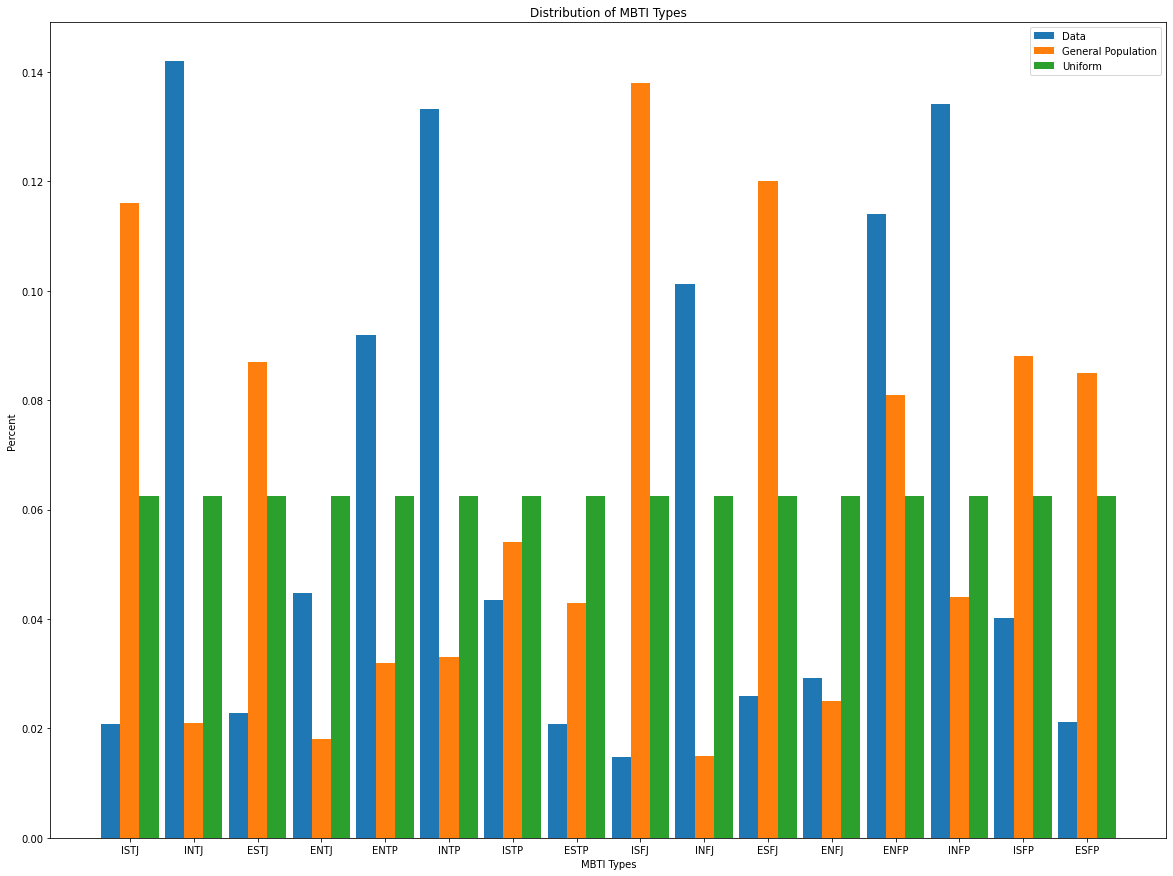

In [28]:
# plot MBTI distributions for data, general population, uniform  

X_axis = np.arange(len(valid_MBTI))  
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(15)


plt.bar(X_axis - .3, mbti_data_pct, 0.3, label = 'Data')
plt.bar(X_axis + 0, mbti_est_gen_pop_pct, 0.3, label = 'General Population')
plt.bar(X_axis + .3, mbti_uniform_pct, 0.3, label = 'Uniform')
  
plt.xticks(X_axis, valid_MBTI)
plt.xlabel("MBTI Types")
plt.ylabel("Percent")
plt.title("Distribution of MBTI Types")
plt.legend()


plt.show()

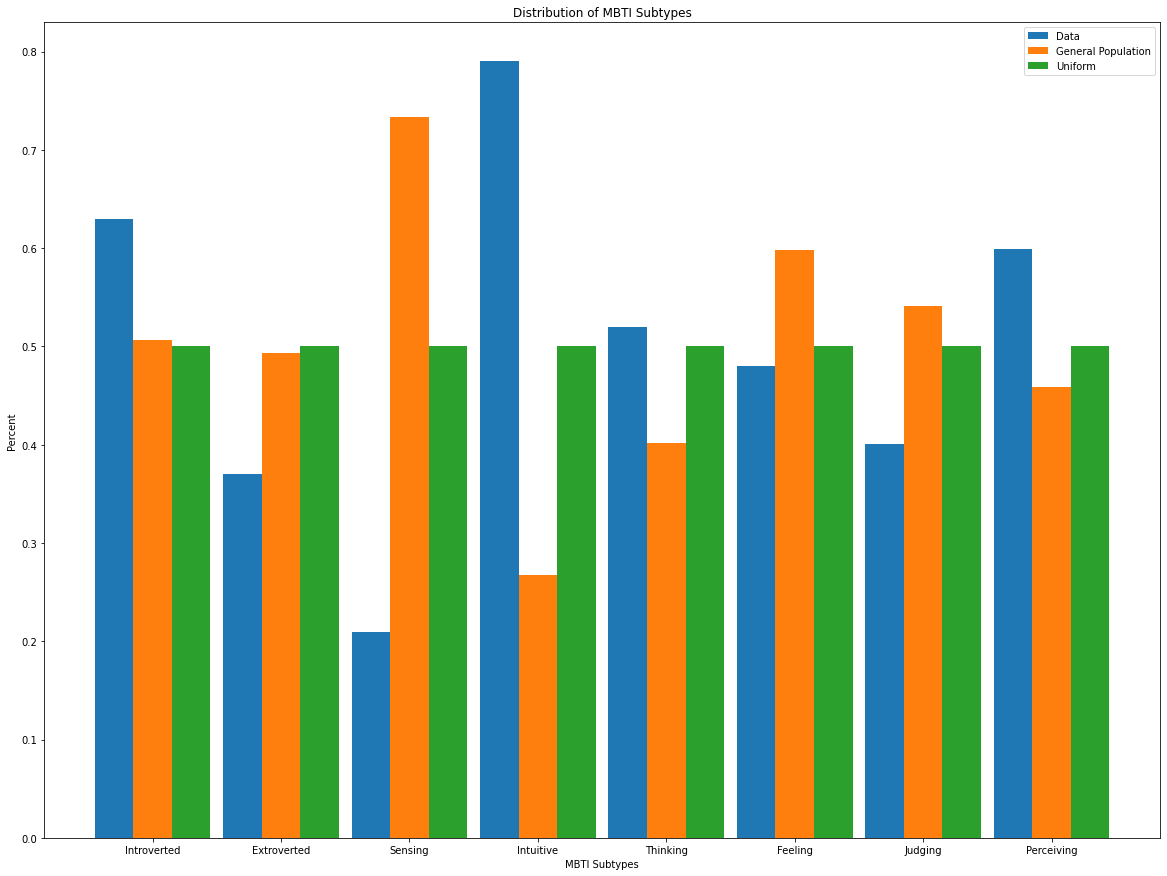

In [29]:
# plot MBTI subtypes distributions for data, general population, uniform  

X_axis = np.arange(len(valid_subtypes))  
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(15)


plt.bar(X_axis - .3, subtypes_data_pct, 0.3, label = 'Data')
plt.bar(X_axis + 0, subtypes_est_gen_pop_pct, 0.3, label = 'General Population')
plt.bar(X_axis + .3, subtypes_uniform_pct, 0.3, label = 'Uniform')
  
plt.xticks(X_axis, valid_subtypes)
plt.xlabel("MBTI Subtypes")
plt.ylabel("Percent")
plt.title("Distribution of MBTI Subtypes")
plt.legend()


plt.show()

In [33]:
# read the Training, Test and Dev splits in from files


# Training
train_X_df = read_parquet_from_gcloud( 'train_mbti_data.parquet')
train_y_df = read_csv_from_gcloud( 'train_mbti_labels.csv')

# put the data back together for the resampling process
train_df  = pd.concat([train_X_df, train_y_df], axis=1)
train_df = train_df.drop(['Unnamed: 0'], axis=1)

print( "train_df shape:", train_df.shape )
print( "train_df columns:", train_df.columns )

# Test
test_X_df = read_parquet_from_gcloud( 'test_mbti_data.parquet')
test_y_df = read_csv_from_gcloud( 'test_mbti_labels.csv')

# put the data back together for analysis
test_df  = pd.concat([test_X_df, test_y_df], axis=1)
test_df = test_df.drop(['Unnamed: 0'], axis=1)
print( "test_df shape:", test_df.shape )
print( "test_df columns:", test_df.columns )


# Dev
dev_X_df = read_parquet_from_gcloud( 'dev_mbti_data.parquet')
dev_y_df = read_csv_from_gcloud( 'dev_mbti_labels.csv')

# put the data back together for analysis
dev_df  = pd.concat([dev_X_df, dev_y_df], axis=1)
dev_df = dev_df.drop(['Unnamed: 0'], axis=1)
print( "dev_df shape:", dev_df.shape )
print( "dev_df columns:", dev_df.columns )




train_df shape: (1200000, 16)
train_df columns: Index(['Username', 'Age', 'Posts', 'Enneagram', 'Instinctual Variant',
       'Gender', 'Occupation', 'is_I', 'is_S', 'is_T', 'is_J', 'post_id',
       'thread_id', 'post_date', 'message', 'MBTI Type'],
      dtype='object')
test_df shape: (400000, 16)
test_df columns: Index(['Username', 'Age', 'Posts', 'Enneagram', 'Instinctual Variant',
       'Gender', 'Occupation', 'is_I', 'is_S', 'is_T', 'is_J', 'post_id',
       'thread_id', 'post_date', 'message', 'MBTI Type'],
      dtype='object')
dev_df shape: (400000, 16)
dev_df columns: Index(['Username', 'Age', 'Posts', 'Enneagram', 'Instinctual Variant',
       'Gender', 'Occupation', 'is_I', 'is_S', 'is_T', 'is_J', 'post_id',
       'thread_id', 'post_date', 'message', 'MBTI Type'],
      dtype='object')


In [34]:
# Now do a sanity check of the distribution in the Training, Test and Dev splits of the data

train_type_counts, train_data_pct, train_sub_data_counts, train_sub_data_pct = get_MBTI_distribution( train_df )
test_type_counts, test_data_pct, test_sub_data_counts, test_sub_data_pct = get_MBTI_distribution( test_df )
dev_type_counts, dev_data_pct, dev_sub_data_counts, dev_sub_data_pct = get_MBTI_distribution( dev_df )


INTJ    180427
INTP    165814
INFP    160191
ENFP    154923
INFJ    140110
ENTP     96227
ISTP     58050
ENTJ     45507
ESFP     32773
ESTP     31526
ESTJ     30144
ENFJ     28401
ESFJ     22173
ISTJ     20249
ISFP     17387
ISFJ     16098
Name: MBTI Type, dtype: int64
[0.016874166666666666, 0.15035583333333333, 0.02512, 0.0379225, 0.08018916666666667, 0.13817833333333332, 0.048375, 0.026271666666666665, 0.013415, 0.11675833333333334, 0.0184775, 0.0236675, 0.1291025, 0.1334925, 0.014489166666666666, 0.027310833333333333]
[758326, 441674, 228400, 971600, 627944, 572056, 483109, 716891]
[0.6319383333333334, 0.3680616666666667, 0.19033333333333333, 0.8096666666666666, 0.5232866666666667, 0.4767133333333333, 0.40259083333333334, 0.5974091666666667]
INTJ    42295
ISFP    30046
ENTJ    23602
ENTP    19129
INFP    17726
INTP    16528
ESFJ    11287
ENFJ     9656
INFJ     7074
ISFJ     6727
ENFP     6312
ISTJ     5648
ISTP     1239
ESTJ     1182
ESFP     1083
ESTP      466
Name: MBTI Type, dtyp

In [35]:
# plot MBTI distributions for data, general population, uniform  

def plot_MBTI_distribution( title, input_MBTI_pct ):

    X_axis = np.arange(len(valid_MBTI))  
    f = plt.figure()
    f.set_figwidth(20)
    f.set_figheight(15)


    plt.bar(X_axis - .3, input_MBTI_pct, 0.3, label = 'Data')
    plt.bar(X_axis + 0, mbti_est_gen_pop_pct, 0.3, label = 'General Population')
    plt.bar(X_axis + .3, mbti_uniform_pct, 0.3, label = 'Uniform')
    
    plt.xticks(X_axis, valid_MBTI)
    plt.xlabel("MBTI Types")
    plt.ylabel("Percent")
    plt.title(title)
    plt.legend()


    plt.show()

def plot_MBTI_subtypes_distribution( title, input_subtypes_dist ):

    X_axis = np.arange(len(valid_subtypes))  
    f = plt.figure()
    f.set_figwidth(20)
    f.set_figheight(15)


    plt.bar(X_axis - .3, input_subtypes_dist, 0.3, label = 'Data')
    plt.bar(X_axis + 0, subtypes_est_gen_pop_pct, 0.3, label = 'General Population')
    plt.bar(X_axis + .3, subtypes_uniform_pct, 0.3, label = 'Uniform')
    
    plt.xticks(X_axis, valid_subtypes)
    plt.xlabel("MBTI Subtypes")
    plt.ylabel("Percent")
    plt.title(title)
    plt.legend()


    plt.show()

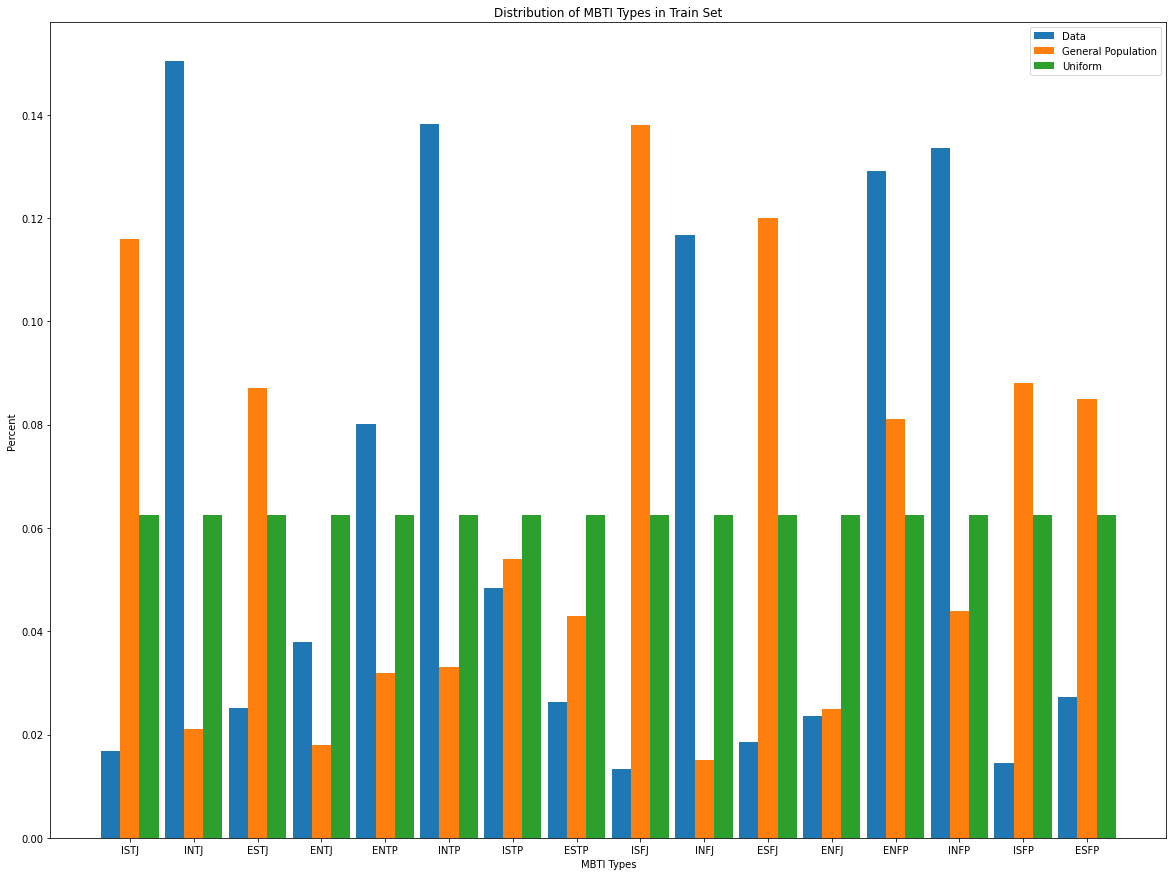

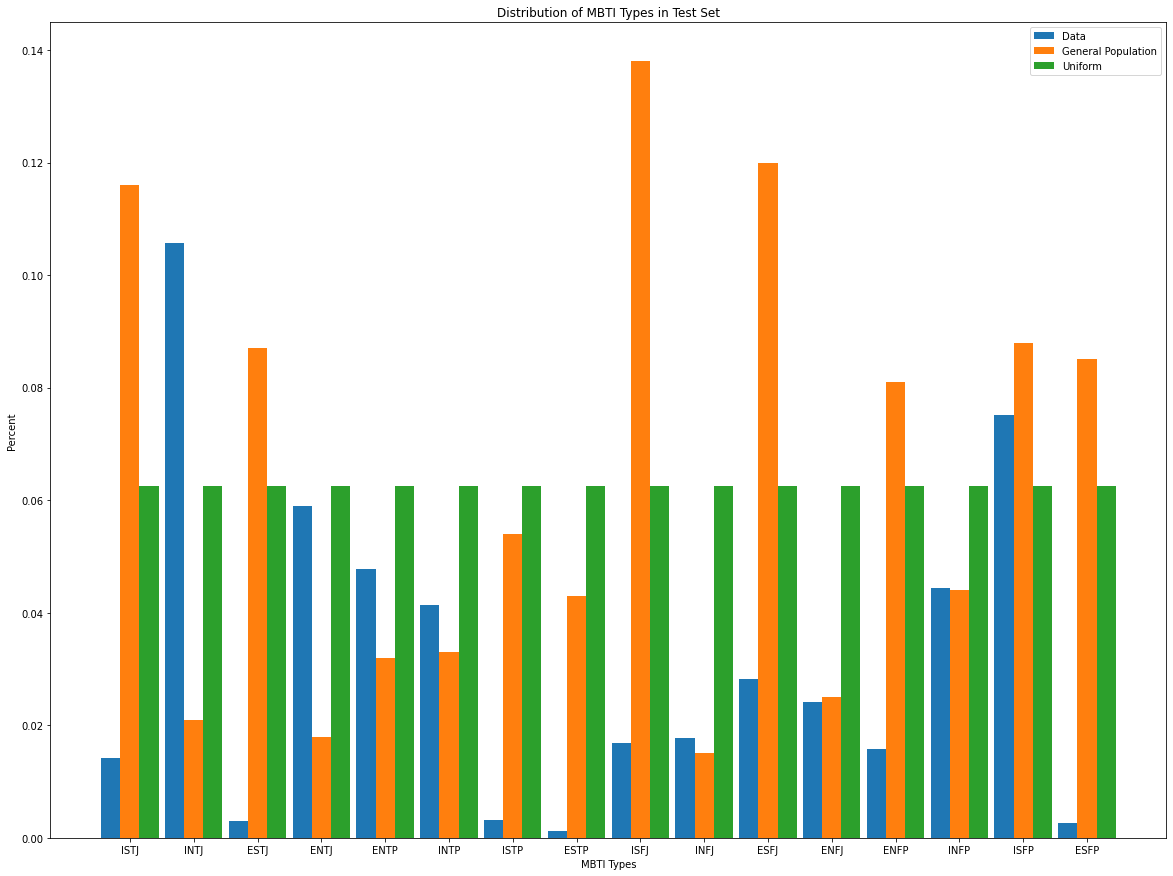

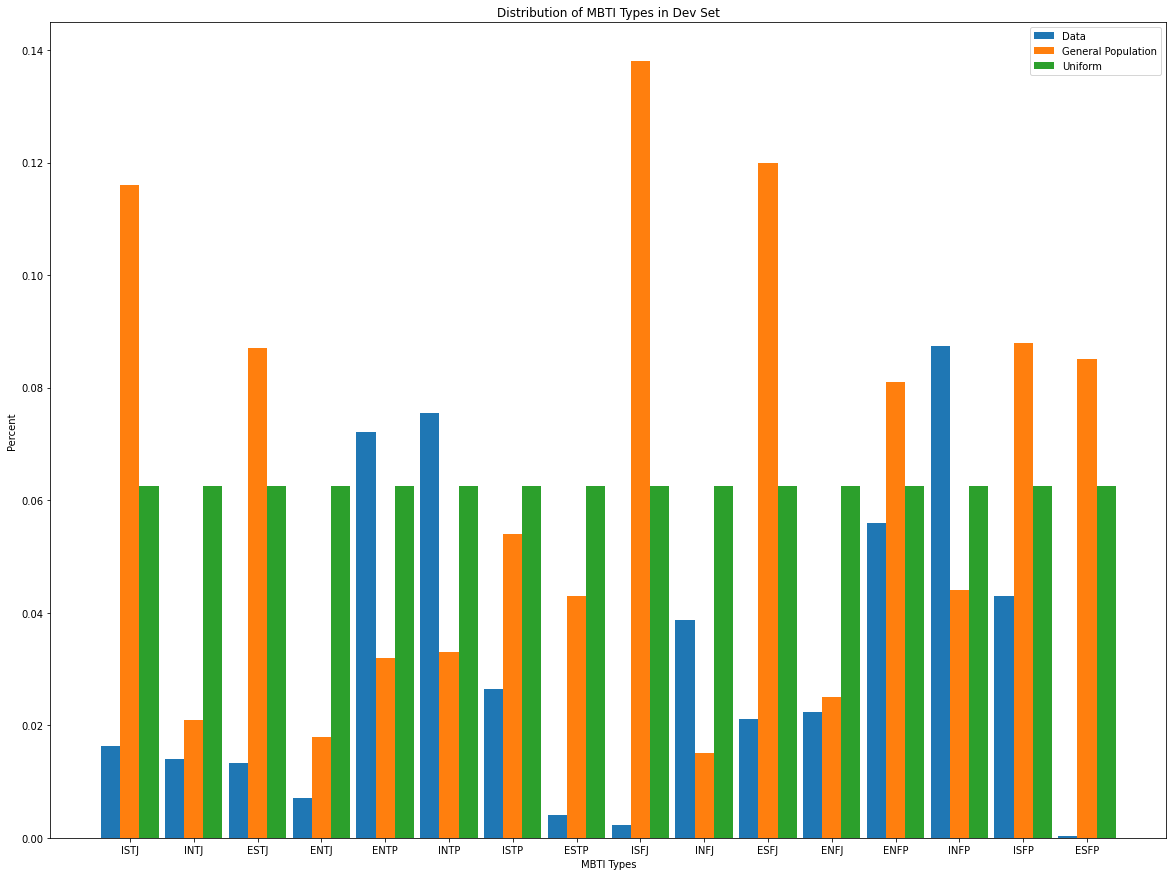

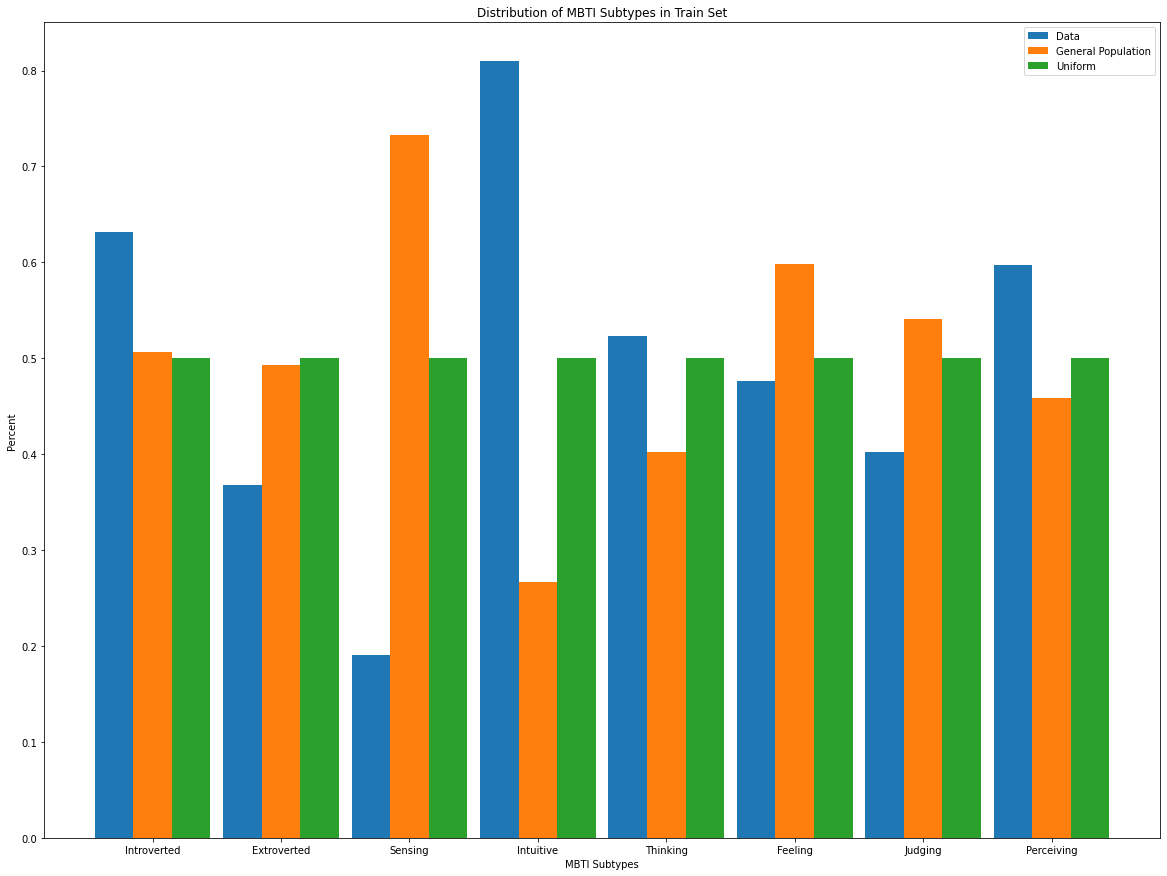

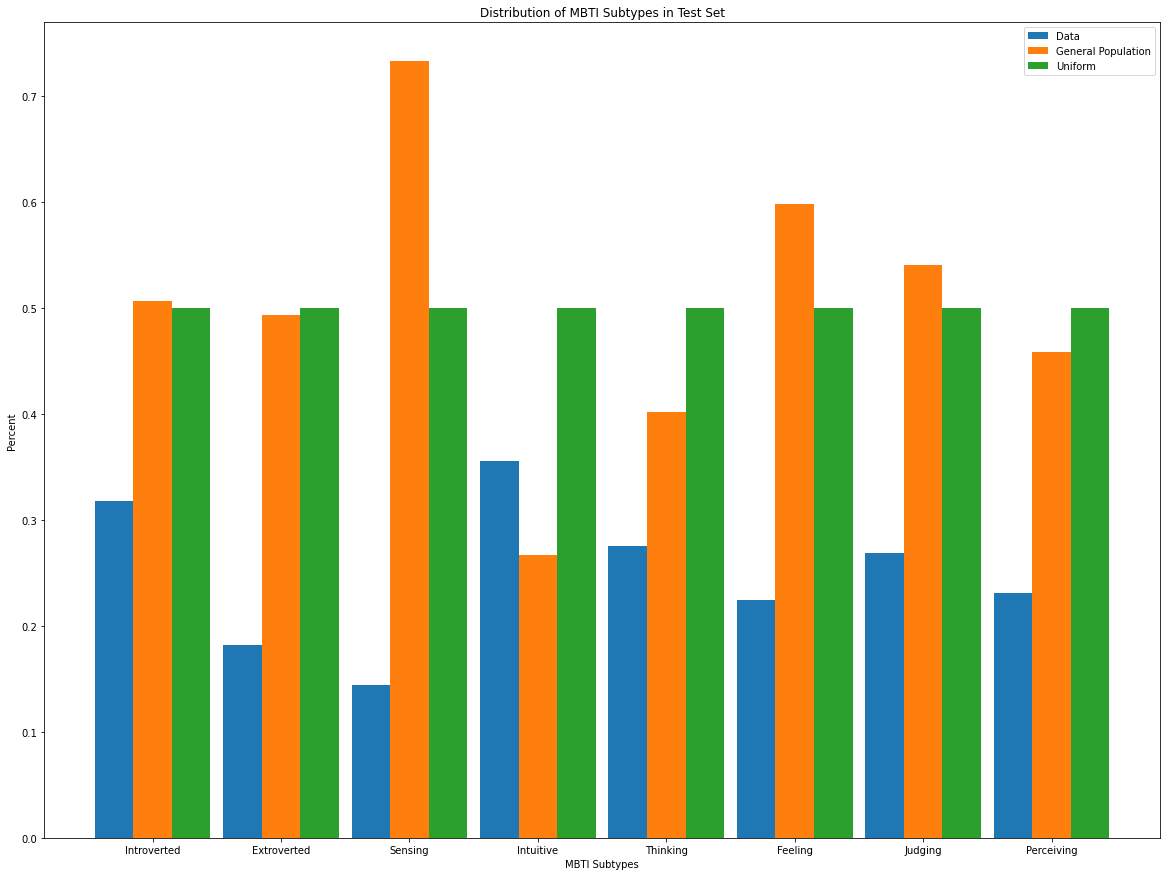

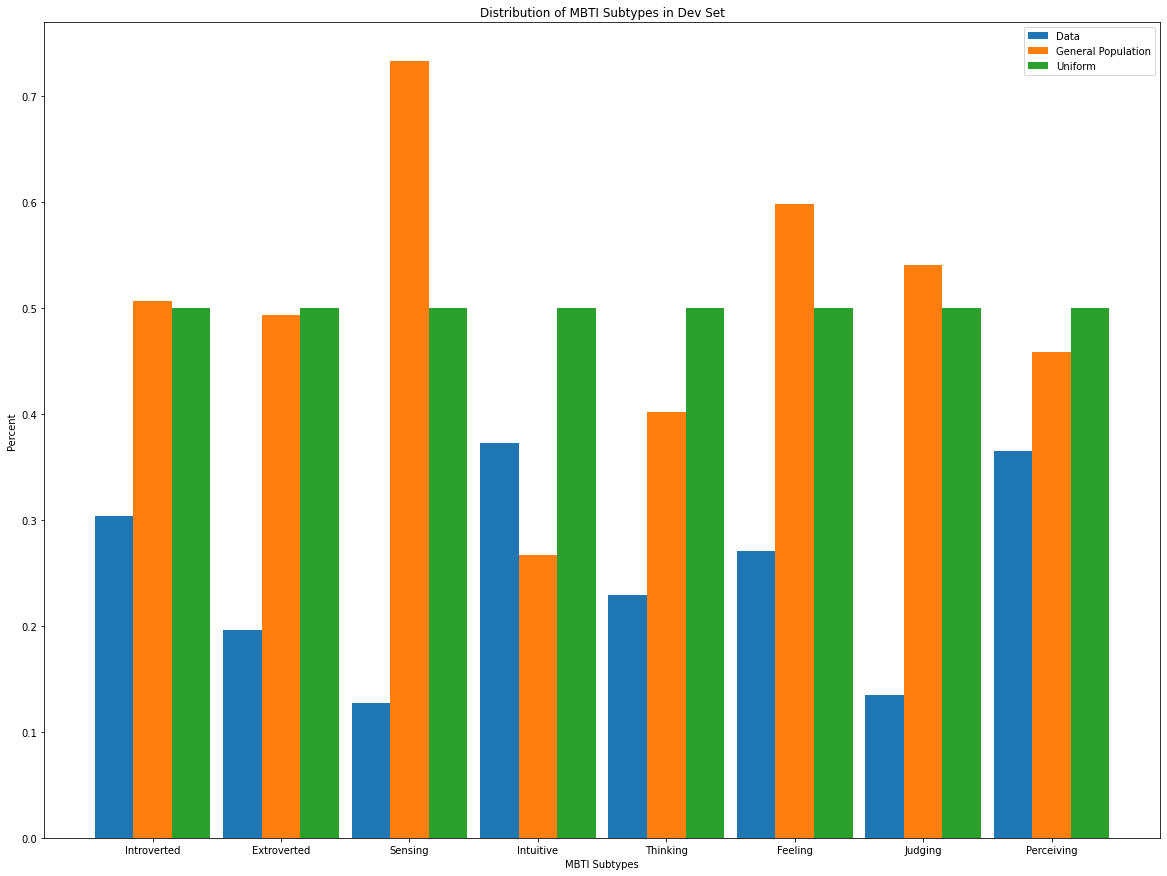

In [36]:
# Let's take a look - we should see the same distribution across the train, test and dev sets

plot_MBTI_distribution( 'Distribution of MBTI Types in Train Set', train_data_pct )
plot_MBTI_distribution( 'Distribution of MBTI Types in Test Set', test_data_pct )
plot_MBTI_distribution( 'Distribution of MBTI Types in Dev Set', dev_data_pct )

plot_MBTI_subtypes_distribution('Distribution of MBTI Subtypes in Train Set', train_sub_data_pct )
plot_MBTI_subtypes_distribution('Distribution of MBTI Subtypes in Test Set', test_sub_data_pct )
plot_MBTI_subtypes_distribution('Distribution of MBTI Subtypes in Dev Set', dev_sub_data_pct )

In [37]:
# Now, resampling

# First, work on uniform distributions which are simpler
# Strategy 1:  Undersampling to uniform
# Strategy 2:  Oversampling to uniform

# Second, match general population distribution
# Strategy 3:  Match general population



resampling_strategy = [ 'uniform_undersampling',
                        'uniform_oversampling',
                        'match_general_population'
                       ]


      

def is_MBTI_type( column_name ):
    return column_name in valid_MBTI


gen_pop_pcts_by_cat = {
    'ISTJ': .116,
    'INTJ': .021,
    'ESTJ': .087,
    'ENTJ': .018,
    'ENTP': .032,
    'INTP': .033,
    'ISTP': .054,
    'ESTP': .043,
    'ISFJ': .138,
    'INFJ': .015,
    'ESFJ': .120,
    'ENFJ': .025,
    'ENFP': .081,
    'INFP': .044,
    'ISFP': .088,
    'ESFP': .085,
    'Introverted': .507,
    'Extroverted': .493,
    'Sensing': .733,
    'Intuitive': .267,
    'Thinking': .402,
    'Feeling': .598,
    'Judging': .541,
    'Perceiving': .459
}

def get_general_pop_pct( category, column_name = None ):
    if column_name == None:
        if category == True:
            print( "invalid category- also need column name")
            return None
        elif category == False:
            print( "invalid category- also need column name")
            return None
        else:
            return gen_pop_pcts_by_cat[category]
    else:
        if column_name == 'is_I':
            if category == True:
                return gen_pop_pcts_by_cat['Introverted']
            else:
                return gen_pop_pcts_by_cat['Extroverted']
        elif column_name == 'is_S':
            if category == True:
                return gen_pop_pcts_by_cat['Sensing']
            else:
                return gen_pop_pcts_by_cat['Intuitive']
        elif column_name == 'is_T':
            if category == True:
                return gen_pop_pcts_by_cat['Thinking']
            else:
                return gen_pop_pcts_by_cat['Feeling']
        elif column_name == 'is_J':
            if category == True:
                return gen_pop_pcts_by_cat['Judging']
            else:
                return gen_pop_pcts_by_cat['Perceiving']
        else:
            return gen_pop_pcts_by_cat[category]


 

In [38]:

def resample_MBTI_data( input_df, column_name, strategy ):

    input_n_samps = input_df.shape[0]
    input_counts = input_df[column_name].value_counts()
   # print( "input counts:", input_counts )
    n_categories = len(input_counts)
    categories_list = input_counts.index
  #  print( "input categories:", categories_list)
    min_count = min(input_counts)
    max_count = max(input_counts)

    categories_dfs = {}

    for cat in categories_list:
        cat_df = input_df.loc[input_df[column_name] == cat]
 #       print( cat_df.shape )
        categories_dfs[cat] = cat_df

    # figure out distribution across categories based on strategy
    target_counts_by_cat = {}

    if strategy == 'uniform_undersampling':
        # find the category or categories with minimum count and reduce all the other categories to the same count
        target_counts = [min_count for cat in categories_list ]
        target_counts_by_cat = dict(zip(categories_list, target_counts))

    elif strategy == 'uniform_oversampling':
        # find the category or categories with maximum count and increase all the other categories to the same count
        target_counts = [max_count for cat in categories_list ]
        target_counts_by_cat = dict(zip(categories_list, target_counts))

    else:
        # for the general population distribution, either over or under sampling means applying the distribution to the counts of the input_df
        # convert distribution to counts array based on the overall size

        for cat in categories_list:
   #         print( "Category:", cat )
            cat_pct = get_general_pop_pct(cat, column_name)
    #        print( "cat_pct:", cat_pct )
            if cat_pct == None:
                print( "Error retrieving target percent for category", cat, column_name )
            cat_count = int(input_n_samps*cat_pct)
  #          print( "Category count:", cat_count)
            target_counts_by_cat[cat] = cat_count


    # now do the resampling to the count in the target_counts_by_cat array for each category
    resampled_dfs = {}

    for cat in categories_list:
        cat_in_df = categories_dfs[cat]
        cat_out_count = target_counts_by_cat[cat]
  #      print( "Category count:", cat_out_count)
        cat_out_df = resample(cat_in_df, replace=True, n_samples = cat_out_count, random_state = 42)
        resampled_dfs[cat] = cat_out_df

    output_df = pd.concat(list(resampled_dfs.values()))

    # shuffle the samples so that they are not sorted by category
    output_df = output_df.sample(frac=1, random_state = 42).reset_index()

    # check what we did
    # for df in resampled_dfs.values():
    #     print( "Df shape:", df.shape)

    # print( "output_df shape:", output_df.shape)
    return output_df



 


In [40]:
# Let's do some resampling and write out different resampled versions of training data and labels

# uniform under sampling MBTI
under_sampled_MBTI_df = resample_MBTI_data( train_df, 'MBTI Type', 'uniform_undersampling')
y_df = under_sampled_MBTI_df['MBTI Type']
X_df = under_sampled_MBTI_df.drop(labels = ['MBTI Type'], axis = 1)

write_parquet_file(X_df, 'train_under_sampled_mbti_data.parquet')
write_csv_file(y_df, 'train_under_sampled_mbti_labels.csv', True, True, 'w')

# uniform over sampling MBTI
over_sampled_MBTI_df = resample_MBTI_data( train_df, 'MBTI Type', 'uniform_oversampling')
y_df = over_sampled_MBTI_df['MBTI Type']
X_df = over_sampled_MBTI_df.drop(labels = ['MBTI Type'], axis = 1)

write_parquet_file(X_df, 'train_over_sampled_mbti_data.parquet')
write_csv_file(y_df, 'train_over_sampled_mbti_labels.csv', True, True, 'w')


# match gen pop MBTI
gen_pop_dist_MBTI_df = resample_MBTI_data( train_df, 'MBTI Type', 'match_general_population')

y_df = gen_pop_dist_MBTI_df['MBTI Type']
X_df = gen_pop_dist_MBTI_df.drop(labels = ['MBTI Type'], axis = 1)

write_parquet_file(X_df, 'train_gen_pop_mbti_data.parquet')
write_csv_file(y_df, 'train_gen_pop_mbti_labels.csv', True, True, 'w')



In [ ]:
# placeholder for creating resampled sets by subtypes